In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

import dgl
from dgl.nn import SAGEConv
import dgl.function as fn
from sklearn.metrics import roc_auc_score
from  load_graph import Load_graph, simple_dataloader

import time
import random
import sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 根据demo定义

In [15]:
def pretraining(g, sloop=False):
    ## 考虑加入自环
    if sloop:
        g = dgl.add_self_loop(g)
    # Split edge set for training and testing
    u, v = g.edges()

    eids = np.arange(g.number_of_edges())
    eids = np.random.permutation(eids)
    test_size = int(len(eids) * 0.1)
    train_size = g.number_of_edges() - test_size
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

    # Find all negative edges and split them for training and testing
    adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
    adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
    neg_u, neg_v = np.where(adj_neg != 0)

    neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

    train_g = dgl.remove_edges(g, eids[:test_size])

    # The following code constructs the positive graph and the negative graph
    # for the training set and the test set respectively.

    train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
    train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

    test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
    test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())
    
    return train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g

In [16]:
# 这次不能犯写node的时候的错误，在定义模型时就将DropEdge考虑进来
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, num_layers, activation, dropedge=False, p=1):
        super(GraphSAGE, self).__init__()
        self.num_layers = num_layers
        self.act = activation
        self.DropEdge = dropedge
        self.p = p
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
        
    def forward(self, g, in_feat):
        if self.DropEdge:   ## 加深GNN，用于节点分类任务
            g = dgl.transforms.DropEdge(p=self.p)(g)
        for i in range(self.num_layers):
            if i==0:
                h = self.act(self.conv1(g, in_feat))
            elif i != (self.num_layers-1):
                h = self.act(self.conv2(g, h))
        return h

In [8]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [9]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [10]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [11]:
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [21]:
def train(model, pred, train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g):
    loss_hist = []
    # ----------- 3. set up loss and optimizer -------------- #
    # in this case, loss will in training loop
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

    # ----------- 4. training -------------------------------- #
    t0 = time.time()
    all_logits = []
    for e in range(100):
        # forward
        h = model(train_g, train_g.ndata['feat'])
        pos_score = pred(train_pos_g, h)
        neg_score = pred(train_neg_g, h)
        loss = compute_loss(pos_score, neg_score)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if e % 5 == 0:
            elapsed = format_time(time.time() - t0)
            print('In epoch {}, loss: {}'.format(e, loss),elapsed)
            loss_hist.append(loss)
    # ----------- 5. check results ------------------------ #
    from sklearn.metrics import roc_auc_score
    with torch.no_grad():
        pos_score = pred(test_pos_g, h)
        neg_score = pred(test_neg_g, h)
        print('AUC', compute_auc(pos_score, neg_score))
    return compute_auc(pos_score, neg_score),loss_hist

In [17]:
hidden_dim = 56
num_layers = 2
activation = F.relu
activation2 = F.elu
activation3 = F.leaky_relu
# dropedge = False
dropedge = True
selfloop = True

### cora 数据集

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
In epoch 0, loss: 0.693115770816803 0:00:00
In epoch 5, loss: 0.6883260607719421 0:00:00
In epoch 10, loss: 0.6781820058822632 0:00:00
In epoch 15, loss: 0.6650975346565247 0:00:00
In epoch 20, loss: 0.6514195203781128 0:00:00
In epoch 25, loss: 0.6383794546127319 0:00:00
In epoch 30, loss: 0.6262768507003784 0:00:00
In epoch 35, loss: 0.6149846911430359 0:00:00
In epoch 40, loss: 0.6043438911437988 0:00:01
In epoch 45, loss: 0.5941929817199707 0:00:01
In epoch 50, loss: 0.5845009684562683 0:00:01
In epoch 55, loss: 0.5753257870674133 0:00:01
In epoch 60, loss: 0.5667077898979187 0:00:01
In epoch 65, loss: 0.55865079164505 0:00:01
In epoch 70, loss: 0.5510613322257996 0:00:01
In epoch 75, loss: 0.5439260601997375 0:00:01
In epoch 80, loss: 0.5371974110603333 0:00:01
In epoch 85, loss: 0.530864953994751 0:00

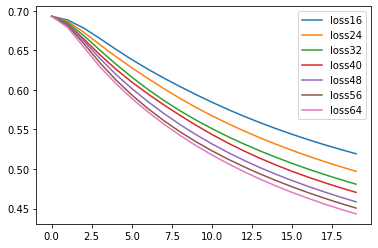

In [24]:
dataset = Load_graph('cora', 'edge')
g = dataset[0]
acc = []
## without self-loop
train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g = pretraining(g)
# without dropedge
for i in range(16,65,8):
    model = GraphSAGE(train_g.ndata['feat'].shape[1], i, num_layers, activation)
    pred = DotPredictor()
    # training
    _,loss = train(model, pred, train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g)
    acc.append(_)
    plt.plot(loss,label = 'loss'+str(i))
plt.legend()
plt.savefig('linkcorahid.pdf')

In [25]:
acc

[0.8977300599716987,
 0.9117045888457133,
 0.9217340131623278,
 0.9267437838323487,
 0.9325891152489836,
 0.9402106870914849,
 0.9371927854271019]

In epoch 0, loss: 0.6930584907531738 0:00:00
In epoch 5, loss: 0.6806027889251709 0:00:00
In epoch 10, loss: 0.657934308052063 0:00:00
In epoch 15, loss: 0.633943498134613 0:00:00
In epoch 20, loss: 0.6123493313789368 0:00:00
In epoch 25, loss: 0.5930836200714111 0:00:00
In epoch 30, loss: 0.5759771466255188 0:00:01
In epoch 35, loss: 0.5607355833053589 0:00:01
In epoch 40, loss: 0.5470806956291199 0:00:01
In epoch 45, loss: 0.5347527265548706 0:00:01
In epoch 50, loss: 0.52358078956604 0:00:01
In epoch 55, loss: 0.5133229494094849 0:00:01
In epoch 60, loss: 0.5038183927536011 0:00:01
In epoch 65, loss: 0.49499282240867615 0:00:01
In epoch 70, loss: 0.48676371574401855 0:00:01
In epoch 75, loss: 0.4790786802768707 0:00:01
In epoch 80, loss: 0.471873939037323 0:00:01
In epoch 85, loss: 0.46506914496421814 0:00:02
In epoch 90, loss: 0.4586220979690552 0:00:02
In epoch 95, loss: 0.4525258541107178 0:00:02
AUC 0.9317652343837741
In epoch 0, loss: 0.6930267810821533 0:00:00
In epoch 5, loss

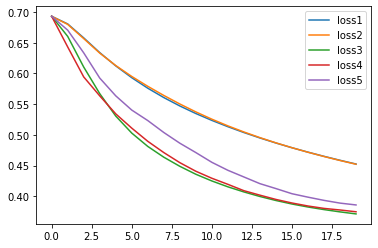

In [28]:
## 56还是好,确定为56隐藏神经元, 比较层数的区别
acc = []
for i in range(1,6):
    model = GraphSAGE(train_g.ndata['feat'].shape[1], 56, i, activation)
    pred = DotPredictor()
    # training
    ac,loss = train(model, pred, train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g)
    acc.append(ac)
    plt.plot(loss,label = 'loss'+str(i))
plt.legend()
plt.savefig('linkcoralay.pdf')


In [29]:
acc

[0.9317652343837741,
 0.9341510747737024,
 0.9344480132970957,
 0.9169075267851127,
 0.9087837200422274]

In [30]:
## 3层效果相对好
hidden_dim = 56
num_layers = 3
activation = F.relu
activation2 = F.elu
activation3 = F.leaky_relu
# dropedge = False
dropedge = True
selfloop = True

In epoch 0, loss: 0.6931039094924927 0:00:00
In epoch 5, loss: 0.6746913194656372 0:00:00
In epoch 10, loss: 0.6472632884979248 0:00:00
In epoch 15, loss: 0.6292847394943237 0:00:00
In epoch 20, loss: 0.6078689098358154 0:00:01
In epoch 25, loss: 0.5867482423782349 0:00:01
In epoch 30, loss: 0.566983699798584 0:00:01
In epoch 35, loss: 0.549588143825531 0:00:01
In epoch 40, loss: 0.5344200134277344 0:00:01
In epoch 45, loss: 0.5206199288368225 0:00:01
In epoch 50, loss: 0.508549690246582 0:00:01
In epoch 55, loss: 0.49758774042129517 0:00:02
In epoch 60, loss: 0.48754405975341797 0:00:02
In epoch 65, loss: 0.4783563017845154 0:00:02
In epoch 70, loss: 0.46983614563941956 0:00:02
In epoch 75, loss: 0.4620928466320038 0:00:02
In epoch 80, loss: 0.45511841773986816 0:00:02
In epoch 85, loss: 0.44861531257629395 0:00:02
In epoch 90, loss: 0.44251900911331177 0:00:02
In epoch 95, loss: 0.4366929233074188 0:00:03
AUC 0.8331048269356034
In epoch 0, loss: 0.6930712461471558 0:00:00
In epoch 5,

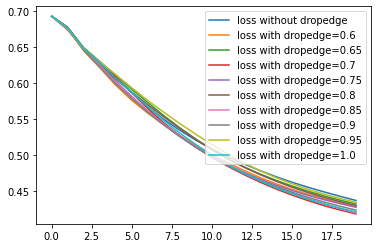

In [34]:
# 比较有无dropedge的区别，
acc = []
model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_dim, num_layers, activation)
pred = DotPredictor()
# training
ac,loss = train(model, pred, train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g)
acc.append(ac)
plt.plot(loss,label = 'loss without dropedge')

for i in range(9):
    p = 0.6+0.05*i
    model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_dim, num_layers, activation,dropedge,p)
    pred = DotPredictor()
    # training
    ac,loss = train(model, pred, train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g)
    acc.append(ac)
    plt.plot(loss,label = 'loss with dropedge='+str(p))
plt.legend()
plt.savefig('linkcoradrop.pdf')

In [35]:
acc

[0.8331048269356034,
 0.8451059050785024,
 0.8503807192111588,
 0.8613324049325036,
 0.8493897261966262,
 0.8611500190921137,
 0.8688376271871701,
 0.8509081107791829,
 0.8379668021832394,
 0.8599079086273892]

In epoch 0, loss: 0.693123459815979 0:00:00
In epoch 5, loss: 0.6784093379974365 0:00:00
In epoch 10, loss: 0.6474060416221619 0:00:00
In epoch 15, loss: 0.6221131086349487 0:00:00
In epoch 20, loss: 0.5991264581680298 0:00:01
In epoch 25, loss: 0.579382061958313 0:00:01
In epoch 30, loss: 0.5596742033958435 0:00:01
In epoch 35, loss: 0.5412484407424927 0:00:01
In epoch 40, loss: 0.5244747400283813 0:00:01
In epoch 45, loss: 0.5096988677978516 0:00:01
In epoch 50, loss: 0.49669477343559265 0:00:01
In epoch 55, loss: 0.48520877957344055 0:00:01
In epoch 60, loss: 0.4748086631298065 0:00:02
In epoch 65, loss: 0.465457946062088 0:00:02
In epoch 70, loss: 0.4570870101451874 0:00:02
In epoch 75, loss: 0.44928494095802307 0:00:02
In epoch 80, loss: 0.4422334134578705 0:00:02
In epoch 85, loss: 0.4357738196849823 0:00:02
In epoch 90, loss: 0.42989158630371094 0:00:02
In epoch 95, loss: 0.42468059062957764 0:00:03
AUC 0.8595287617079581
In epoch 0, loss: 0.6925650238990784 0:00:00
In epoch 5, 

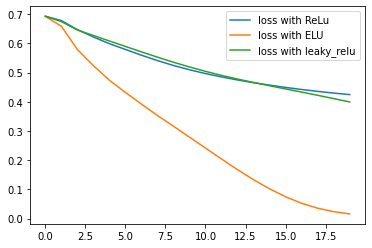

In [39]:
# 0.7,0.8,0.85的效果相对明显好一点，选0.85（它最大，loss第二好），比较不同激活函数：
acc = []
model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_dim, num_layers, activation,dropedge,0.85)
pred = DotPredictor()
# training
ac,loss = train(model, pred, train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g)
acc.append(ac)
plt.plot(loss,label = 'loss with ReLu')

model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_dim, num_layers, activation2,dropedge,0.85)
pred = DotPredictor()
# training
ac,loss = train(model, pred, train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g)
acc.append(ac)
plt.plot(loss,label = 'loss with ELU')

model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_dim, num_layers, activation3,dropedge,0.85)
pred = DotPredictor()
# training
ac,loss = train(model, pred, train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g)
acc.append(ac)
plt.plot(loss,label = 'loss with leaky_relu')

plt.legend()
plt.savefig('linkcoraact.pdf')

In [40]:
acc

[0.8595287617079581, 0.852263875474495, 0.8616455155993802]

In epoch 0, loss: 0.6922379732131958 0:00:00
In epoch 5, loss: 0.6745542287826538 0:00:00
In epoch 10, loss: 0.6120204329490662 0:00:00
In epoch 15, loss: 0.548605740070343 0:00:00
In epoch 20, loss: 0.49432259798049927 0:00:01
In epoch 25, loss: 0.4484215974807739 0:00:01
In epoch 30, loss: 0.4090607464313507 0:00:01
In epoch 35, loss: 0.3678625822067261 0:00:01
In epoch 40, loss: 0.3288845717906952 0:00:01
In epoch 45, loss: 0.28953319787979126 0:00:01
In epoch 50, loss: 0.2509356439113617 0:00:01
In epoch 55, loss: 0.21347267925739288 0:00:02
In epoch 60, loss: 0.17729276418685913 0:00:02
In epoch 65, loss: 0.14282073080539703 0:00:02
In epoch 70, loss: 0.11057176440954208 0:00:02
In epoch 75, loss: 0.0820503681898117 0:00:02
In epoch 80, loss: 0.05838025361299515 0:00:02
In epoch 85, loss: 0.039900194853544235 0:00:03
In epoch 90, loss: 0.026659255847334862 0:00:03
In epoch 95, loss: 0.017869455739855766 0:00:03
AUC 0.8354888704207004
In epoch 0, loss: 0.6902210712432861 0:00:00
In

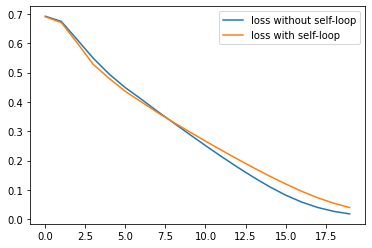

In [41]:
# ELU激活时的loss收敛快效果好，但leaky_relu的预测结果好，用ELU看有无自环
acc = []
## without self-loop
train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g = pretraining(g)
model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_dim, num_layers, activation2, dropedge, 0.85)
pred = DotPredictor()
# training
ac,loss = train(model, pred, train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g)
acc.append(ac)
plt.plot(loss,label = 'loss without self-loop')
## with self-loop
train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g = pretraining(g,selfloop)
model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_dim, num_layers, activation2, dropedge, 0.85)
pred = DotPredictor()
# training
ac,loss = train(model, pred, train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g)
acc.append(ac)
plt.plot(loss,label = 'loss with self-loop')

plt.legend()
plt.savefig('linkcoraloop.pdf')


In [42]:
acc

[0.8354888704207004, 0.8626404500772348]

### citeseer 数据集

In [43]:
hidden_dim = 56
num_layers = 3
activation = F.relu
activation2 = F.elu
activation3 = F.leaky_relu
dropedge = True
selfloop = True

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
In epoch 0, loss: 0.6928827166557312 0:00:00
In epoch 5, loss: 0.6616485714912415 0:00:00
In epoch 10, loss: 0.5789589285850525 0:00:01
In epoch 15, loss: 0.5180569291114807 0:00:01
In epoch 20, loss: 0.4673038721084595 0:00:01
In epoch 25, loss: 0.4200694262981415 0:00:01
In epoch 30, loss: 0.37455078959465027 0:00:02
In epoch 35, loss: 0.3312720060348511 0:00:02
In epoch 40, loss: 0.28857600688934326 0:00:02
In epoch 45, loss: 0.2437824308872223 0:00:02
In epoch 50, loss: 0.20006954669952393 0:00:03
In epoch 55, loss: 0.15720781683921814 0:00:03
In epoch 60, loss: 0.1174028068780899 0:00:03
In epoch 65, loss: 0.0832277163863182 0:00:03
In epoch 70, loss: 0.0560615174472332 0:00:04
In epoch 75, loss: 0.03655165806412697 0:00:04
In epoch 80, loss: 0.02370203100144863 0:00:04
In epoch 85, loss: 0.015812437981

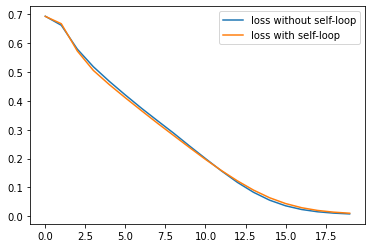

In [44]:
dataset = Load_graph('citeseer', 'edge')
g = dataset[0]
acc = []

train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g = pretraining(g)
model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_dim, num_layers, activation2, dropedge, 0.85)
pred = DotPredictor()
# training
ac,loss = train(model, pred, train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g)
acc.append(ac)
plt.plot(loss,label = 'loss without self-loop')
## with self-loop
train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g = pretraining(g,selfloop)
model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_dim, num_layers, activation2, dropedge, 0.85)
pred = DotPredictor()
# training
ac,loss = train(model, pred, train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g)
acc.append(ac)
plt.plot(loss,label = 'loss with self-loop')

plt.legend()
plt.savefig('linkciteloop.pdf')



In [45]:
acc

[0.8602632210463906, 0.8880500309518897]

### ppi 数据集

In [47]:
dataset = Load_graph('ppi')
loader = simple_dataloader(dataset=dataset)
pred = DotPredictor()

In [48]:
loss1 = []
acc1 = []
loss2 = []
acc2 = []
for g in loader:
    train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g = pretraining(g)
    model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_dim, num_layers, activation2, dropedge,0.85)
    ac,lo = train(model, pred, train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g)
    acc1.append(ac)
    loss1.append(min(lo))
    
    train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g = pretraining(g,selfloop)
    model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_dim, num_layers, activation2, dropedge,0.85)
    ac,lo = train(model, pred, train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g)
    acc2.append(ac)
    loss2.append(min(lo))


In epoch 0, loss: 9.125266075134277 0:00:00
In epoch 5, loss: 1.5547258853912354 0:00:00
In epoch 10, loss: 1.1718202829360962 0:00:00
In epoch 15, loss: 1.0194028615951538 0:00:00
In epoch 20, loss: 0.940670371055603 0:00:00
In epoch 25, loss: 0.8591389656066895 0:00:01
In epoch 30, loss: 0.8074642419815063 0:00:01
In epoch 35, loss: 0.7725124955177307 0:00:01
In epoch 40, loss: 0.7472639679908752 0:00:01
In epoch 45, loss: 0.7282122373580933 0:00:01
In epoch 50, loss: 0.7149364948272705 0:00:01
In epoch 55, loss: 0.7052713632583618 0:00:01
In epoch 60, loss: 0.6978251338005066 0:00:01
In epoch 65, loss: 0.6919984221458435 0:00:01
In epoch 70, loss: 0.6873515248298645 0:00:01
In epoch 75, loss: 0.6836835145950317 0:00:02
In epoch 80, loss: 0.6807164549827576 0:00:02
In epoch 85, loss: 0.6782485246658325 0:00:02
In epoch 90, loss: 0.6761800646781921 0:00:02
In epoch 95, loss: 0.6743874549865723 0:00:02
AUC 0.6028970613232255
In epoch 0, loss: 9.057665824890137 0:00:00
In epoch 5, loss:

In [49]:
print(torch.mean(torch.tensor(acc1)),torch.mean(torch.tensor(loss1)))
print(torch.mean(torch.tensor(acc2)),torch.mean(torch.tensor(loss2)))

tensor(0.6152, dtype=torch.float64) tensor(0.6691)
tensor(0.6192, dtype=torch.float64) tensor(0.6646)
